## This notebook is meant to do build upon the insights derived from basic data exploration on FanAI DC datasets. The goal is to create new features using the data upon which a robust classification model can be built.

### Let's import relevant packages.

In [1]:
%matplotlib inline 
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import chisquare
import os
import seaborn as sns
#sns.set()

import pandas as pd
from pandas import datetime
import pandas_profiling
from pandas import Series


# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier
import sklearn.preprocessing as preprocessing

### Read all the data files

In [2]:
data_dir = '/Users/aprakash/LA_IDX_2019/FanAI/data/'

customers = pd.read_csv(data_dir+ 'customers.csv')
final_sales = pd.read_csv(data_dir+ 'final_sales.csv')
products = pd.read_csv(data_dir+ 'products.csv')
transactions = pd.read_csv(data_dir+ 'transactions.csv')


### Write functions which will assign numerical values to encoded variables and create new features

In [3]:
#feature funtions
def age_group_2_age(age_group):
    age_group = age_group.strip()
    if age_group =='A':
        Age = 20.0
    elif age_group =='B':
        Age = 27
    elif age_group =='C':
        Age = 32
    elif age_group =='D':
        Age = 37
    elif age_group =='E':
        Age = 42
    elif age_group =='F':
        Age = 47
    elif age_group =='G':
        Age = 52
    elif age_group =='H':
        Age = 57
    elif age_group =='I':
        Age = 62
    elif age_group =='J':
        Age = 67
    elif age_group =='K':
        Age = 75
    else:
        Age = 75
    return Age

def zip_2_distance(zip_group):
    zip_group = zip_group.strip()
    if zip_group =='E':
        Distance = 0
    elif zip_group =='F':
        Distance = 0
    else:
        Distance = 1
    return Distance


def roc_plot(fpr, tpr):
    plt.plot(fpr, tpr, color='Red', label='ROC')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.grid()
    plt.minorticks_on()
    plt.legend()
    plt.show()


### Create binary feature "Far_Distance" which is 0 for customers living closer (E,F) to the store and 1 for customers living farther away (A, B, C, D, G, H). Assuming H (unknown) is also far away 

### Assign numerical value to Age_group in a new column Age

In [4]:
customers['Age'] = customers['age_group'].apply(age_group_2_age)
customers['Far_Distance'] = customers['residence_area_code'].apply(zip_2_distance)
customers.head()

,customer_id,age_group,residence_area_code,weight_lb,height_inchess,Age,Far_Distance
0,141833,F,F,177.584594,67.723504,47.0,0
1,1376753,E,E,199.391791,66.781226,42.0,0
2,1603071,E,G,198.898502,73.144212,42.0,1
3,1738667,E,F,240.695857,61.559766,42.0,0
4,2141497,A,B,192.286505,62.239804,20.0,1


### Since the goal is to build a model which would predict if the customer will spend >1500 based on Final_sales, I create another binary feature "high_spender" which is 0 for customers spending <1500 and 1 for customers spending > 1500. This is the target variable for classification.

In [5]:
final_sales['high_spender'] = (final_sales['sales_price'] >= 1500).astype('int')
final_sales.head()

,customer_id,sales_price,transaction_date,high_spender
0,1069,290,2001-02-10,0
1,1113,628,2001-01-06,0
2,1250,849,2001-02-10,0
3,1359,364,2000-12-04,0
4,1823,433,2001-01-24,0


### Assemble the data in one data frame by joining of common keys

In [6]:
trans_w_product  = pd.merge(transactions,products, on='product_id', how='left')
trans_n_customer = pd.merge(trans_w_product,customers, on='customer_id', how='left')

In [7]:
trans_n_customer.head()

,transaction_date,customer_id,product_id,quantity,sales_price,product_class,weight_class,color_code,locally_sourced,age_group,residence_area_code,weight_lb,height_inchess,Age,Far_Distance
0,2001-01-01,141833,4710105011011,2,52,130207,8,0,0,F,F,177.584594,67.723504,47.0,0
1,2001-01-01,1376753,4710265849066,1,129,110217,2,1,1,E,E,199.391791,66.781226,42.0,0
2,2001-01-01,1603071,4712019100607,1,39,100201,2,5,0,E,G,198.898502,73.144212,42.0,1
3,2001-01-01,1738667,4710168702901,1,119,530105,9,1,0,E,F,240.695857,61.559766,42.0,0
4,2001-01-01,2141497,4710431339148,1,159,320407,5,2,0,A,B,192.286505,62.239804,20.0,1


### Using this dataset I can derive new features on customer purchasing behavior
### First, I combine the sales by day for each customer since everything purchased on the same date is considered part of the same order.
### Second, I also sum the number of items bought on the same day for each customer 

In [8]:
e = trans_n_customer.groupby(['customer_id', 'transaction_date'])['sales_price'].sum()
f =trans_n_customer.groupby(['customer_id', 'transaction_date'])['quantity'].sum()

c = pd.merge(e,f,left_index=True,right_index=True)
c.sort_values(['customer_id', 'transaction_date'], ascending=[True, True])


sales_price  quantity
customer_id transaction_date                       
1069        2000-11-13                187         2
            2001-01-21                971         3
            2001-02-03                496         9
            2001-02-10                290         2
1113        2000-11-12                420         5
            2000-11-26                558         3
            2000-11-27                624         6
            2001-01-06                628         9
1250        2001-02-04                734         5
            2001-02-10                849        13
1359        2000-12-04                364         4
1823        2000-11-02               1256        16
            2000-11-06                918         6
            2001-01-24                433         3
2189        2000-12-02               9078        89
            2001-01-03               4978        52
3667        2000-12-08                979         8
            2000-12-26               8960         4
            2001-02-01               1241        11
            2001-02-08                329         3
4282        2000-12-15                171         2
            2001-01-13                796         7
4381        2000-11-18                701        13
4947        2000-12-03               1875        24
            2000-12-10               1488        16
4961        2001-02-05                553         8
4978        2001-01-03               1251        12
            2001-01-22               1194        13
5241        2000-12-16                325         6
            2001-01-07                991        20
...                                   ...       ...
2179568     2001-02-28                406         5
2179605     2001-02-28               6001        70
2179643     2001-02-28                887        28
20002000    2000-11-08                 48         3
            2000-11-11                 30         2
            2000-11-12                400         2
            2000-11-20                270         1
            2000-11-25              10492       125
            2000-11-26              10090       113
            2000-11-27                153         4
            2000-11-28                813        10
            2000-11-29                236         4
            2000-12-02                250         3
            2000-12-03               9213        99
            2000-12-04               1017        21
            2000-12-05               2994        41
            2000-12-06                340         3
            2000-12-07                439        13
            2000-12-08                689        10
            2000-12-10                807        10
            2000-12-11               2110        23
            2000-12-12                694        25
            2000-12-13                100         1
            2000-12-14                827        19
            2000-12-15               2232        17
            2000-12-16               2404        28
            2000-12-17                760        16
            2000-12-18                911        27
            2001-01-20               1075         9
            2001-02-05                 72         6

[119578 rows x 2 columns]

In [9]:
c.reset_index()

,customer_id,transaction_date,sales_price,quantity
0,1069,2000-11-13,187,2
1,1069,2001-01-21,971,3
2,1069,2001-02-03,496,9
3,1069,2001-02-10,290,2
4,1113,2000-11-12,420,5
5,1113,2000-11-26,558,3
6,1113,2000-11-27,624,6
7,1113,2001-01-06,628,9
8,1250,2001-02-04,734,5
9,1250,2001-02-10,849,13


### This new dataframe gives us a time series for each customer where for a given date we have the aggregate purchasing price and total number of items.

### Using these time series for each customer, I can create new features which is average speding by a customer on a day and average number of items purchased in a day.

### Rename the columns to reflect their true value.


In [10]:
g = c.groupby(['customer_id'])['sales_price'].mean()
h = c.groupby(['customer_id'])['quantity'].mean()
d = pd.merge(g,h,left_index=True,right_index=True)
d.reset_index()

,customer_id,sales_price,quantity
0,1069,486.000000,4.000000
1,1113,557.500000,5.750000
2,1250,791.500000,9.000000
3,1359,364.000000,4.000000
4,1823,869.000000,8.333333
5,2189,7028.000000,70.500000
6,3667,2877.250000,6.500000
7,4282,483.500000,4.500000
8,4381,701.000000,13.000000
9,4947,1681.500000,20.000000


In [11]:
d.rename(columns={'sales_price': 'average_spending', 'quantity': 'average_number_items'}, inplace=True)

### Combine customer demographic data with average spending data-frame

In [12]:
ii = pd.merge(d,customers, on='customer_id', how='inner')
ii.head()


,customer_id,average_spending,average_number_items,age_group,residence_area_code,weight_lb,height_inchess,Age,Far_Distance
0,1069,486.0,4.000000,K,E,168.667742,75.119849,75.0,0
1,1113,557.5,5.750000,K,F,248.964319,67.625904,75.0,0
2,1250,791.5,9.000000,D,D,246.760186,62.941846,37.0,1
3,1359,364.0,4.000000,K,G,173.750503,69.696075,75.0,1
4,1823,869.0,8.333333,K,D,193.430925,69.043059,75.0,1


### Final dataframe is merged with final_sales containing target variable("high_spender") which is estimated based on if sales_price >1500 
### redundant columns are dropped since their feature has been extracted in opther column

In [13]:
jj = pd.merge(ii,final_sales, on='customer_id', how='inner')
jj.head()

,customer_id,average_spending,average_number_items,age_group,residence_area_code,weight_lb,height_inchess,Age,Far_Distance,sales_price,transaction_date,high_spender
0,1069,486.0,4.000000,K,E,168.667742,75.119849,75.0,0,290,2001-02-10,0
1,1113,557.5,5.750000,K,F,248.964319,67.625904,75.0,0,628,2001-01-06,0
2,1250,791.5,9.000000,D,D,246.760186,62.941846,37.0,1,849,2001-02-10,0
3,1359,364.0,4.000000,K,G,173.750503,69.696075,75.0,1,364,2000-12-04,0
4,1823,869.0,8.333333,K,D,193.430925,69.043059,75.0,1,433,2001-01-24,0


In [14]:
final_df= jj.drop(['age_group', 'residence_area_code','sales_price'], axis=1)
final_df.head()

,customer_id,average_spending,average_number_items,weight_lb,height_inchess,Age,Far_Distance,transaction_date,high_spender
0,1069,486.0,4.000000,168.667742,75.119849,75.0,0,2001-02-10,0
1,1113,557.5,5.750000,248.964319,67.625904,75.0,0,2001-01-06,0
2,1250,791.5,9.000000,246.760186,62.941846,37.0,1,2001-02-10,0
3,1359,364.0,4.000000,173.750503,69.696075,75.0,1,2000-12-04,0
4,1823,869.0,8.333333,193.430925,69.043059,75.0,1,2001-01-24,0


### At this point data is ready to be modeled
### split the dataset in training : test (80:20) usimng random sampling.

In [15]:
np.random.seed(42)
final_df['is_train'] = np.random.uniform(0, 1, len(final_df)) <= .80

In [16]:
train, test = final_df[final_df['is_train']==True], final_df[final_df['is_train']==False]
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 25831
Number of observations in the test data: 6435


### Create a list of fetures (independent variables) and define target variable

In [17]:
Indep_var =final_df.columns[:7]

# View features
Indep_var

Index(['customer_id', 'average_spending', 'average_number_items', 'weight_lb',
       'height_inchess', 'Age', 'Far_Distance'],
      dtype='object')

In [18]:
target_var = train['high_spender']

target_var

0        0
2        0
3        0
4        0
5        1
6        0
8        0
9        0
10       0
13       0
14       1
15       0
16       0
17       1
18       1
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
30       0
31       1
32       1
36       0
        ..
32233    0
32234    0
32235    0
32236    0
32237    0
32238    0
32239    0
32240    0
32241    1
32242    0
32244    0
32245    1
32247    0
32248    0
32249    0
32250    1
32251    1
32252    0
32253    0
32254    1
32256    1
32257    0
32258    0
32259    0
32260    1
32261    1
32262    0
32263    1
32264    0
32265    0
Name: high_spender, Length: 25831, dtype: int64

### Create a simple Random forest classifier using sufficiently large number of trees 
### and ensure that bootstrapped subsmaples are balanced (since the data is inherently unbalanced)
### train the classifier on the trainign data and test it on test data.

In [19]:

clf = RandomForestClassifier(n_estimators = 50, random_state=0, class_weight= 'balanced_subsample')

clf.fit(train[Indep_var], target_var)

# Apply the Classifier we trained to the test data (which, remember, it has never seen before)
preds = clf.predict(test[Indep_var])

### View the predicted probabilities of the observations

In [20]:
predicted_prob = clf.predict_proba(test[Indep_var])
predicted_prob

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [0.88, 0.12],
       ...,
       [0.16, 0.84],
       [1.  , 0.  ],
       [0.3 , 0.7 ]])

### Create confusion matrix

In [21]:
pd.crosstab(test['high_spender'], preds, rownames=['Actual spending'], colnames=['Predicted Spending'])

Predicted Spending,0,1
Actual spending,,
0,4871,267
1,292,1005


### View the list of features and their importance scores (a very useful and important feature of Random forrest)

### plot the feature score for convenience

In [22]:
list(zip(train[Indep_var], clf.feature_importances_))

[('customer_id', 0.06568361032825108),
 ('average_spending', 0.5502051514715015),
 ('average_number_items', 0.2208080503562337),
 ('weight_lb', 0.06389440462045105),
 ('height_inchess', 0.062425005305223574),
 ('Age', 0.028008164425812398),
 ('Far_Distance', 0.00897561349252679)]

In [23]:
print(preds[0:15])
print(test['high_spender'][0:15])

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 1]
1     0
7     0
11    0
12    0
33    0
34    0
35    1
43    0
50    0
52    0
53    0
55    0
62    0
67    0
69    1
Name: high_spender, dtype: int64


Text(0.5, 0, 'Feature')

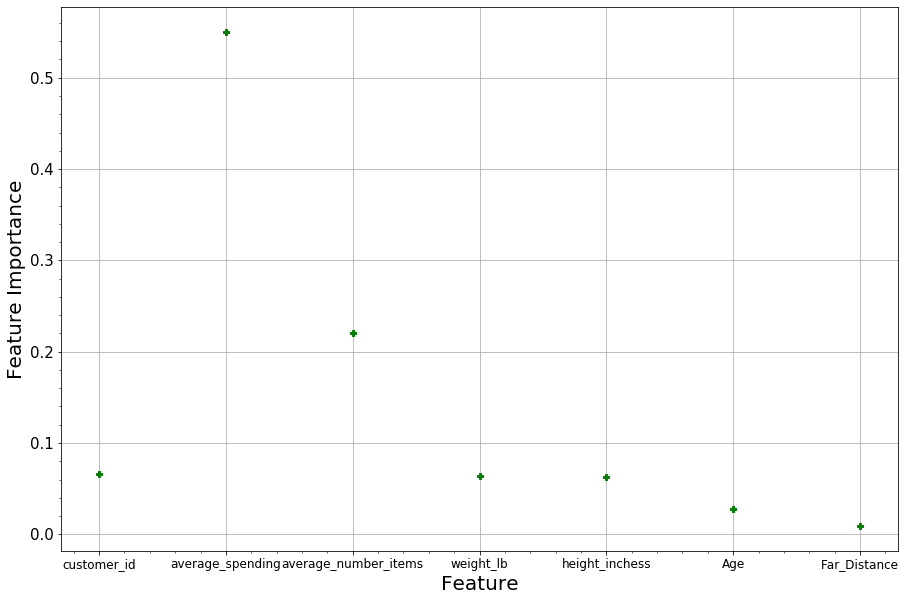

In [24]:
plt.figure(figsize=(15,10))
plt.plot(Indep_var, clf.feature_importances_,'gP')
plt.ylabel('Feature Importance', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
plt.grid()
plt.minorticks_on()
plt.xlabel('Feature', fontsize=20)

### Estimate different metrics of performace of the model using confusion matrix 

In [25]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

actual = test['high_spender'] 
predicted = preds
results = confusion_matrix(actual, predicted) 
print('Confusion Matrix :')
print(results) 

acc_score = accuracy_score(actual, predicted)
print('Accuracy Score :',accuracy_score(actual, predicted))
print('Report : ')
print(classification_report(actual, predicted))

Confusion Matrix :
[[4871  267]
 [ 292 1005]]
Accuracy Score : 0.9131313131313131
Report : 
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      5138
           1       0.79      0.77      0.78      1297

    accuracy                           0.91      6435
   macro avg       0.87      0.86      0.86      6435
weighted avg       0.91      0.91      0.91      6435



### ROC Analysis

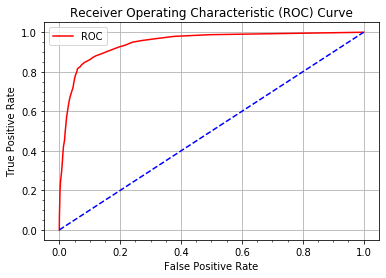

In [26]:
fpr, tpr, thresholds = roc_curve(actual,predicted_prob[:,1],pos_label=1)
roc_plot(fpr, tpr)

In [27]:
auc = roc_auc_score(actual,predicted_prob[:,1])
print('AUC: %.2f' %auc)

AUC: 0.95


### Done!

Model can be improved further by following tests
1. adding/removing features
2. Tune hyperparameters of Random forest classifier (no. of estimators, depth of trees, no. of features etc)